In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ARIMA Order: {'order': (1, 0, 0)}
Best MAE Score: -1127.3553704128453


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (Testing Set - CPU Usage): 1127.3553704128453
Mean Squared Error (Testing Set - CPU Usage): 2157301.645060323


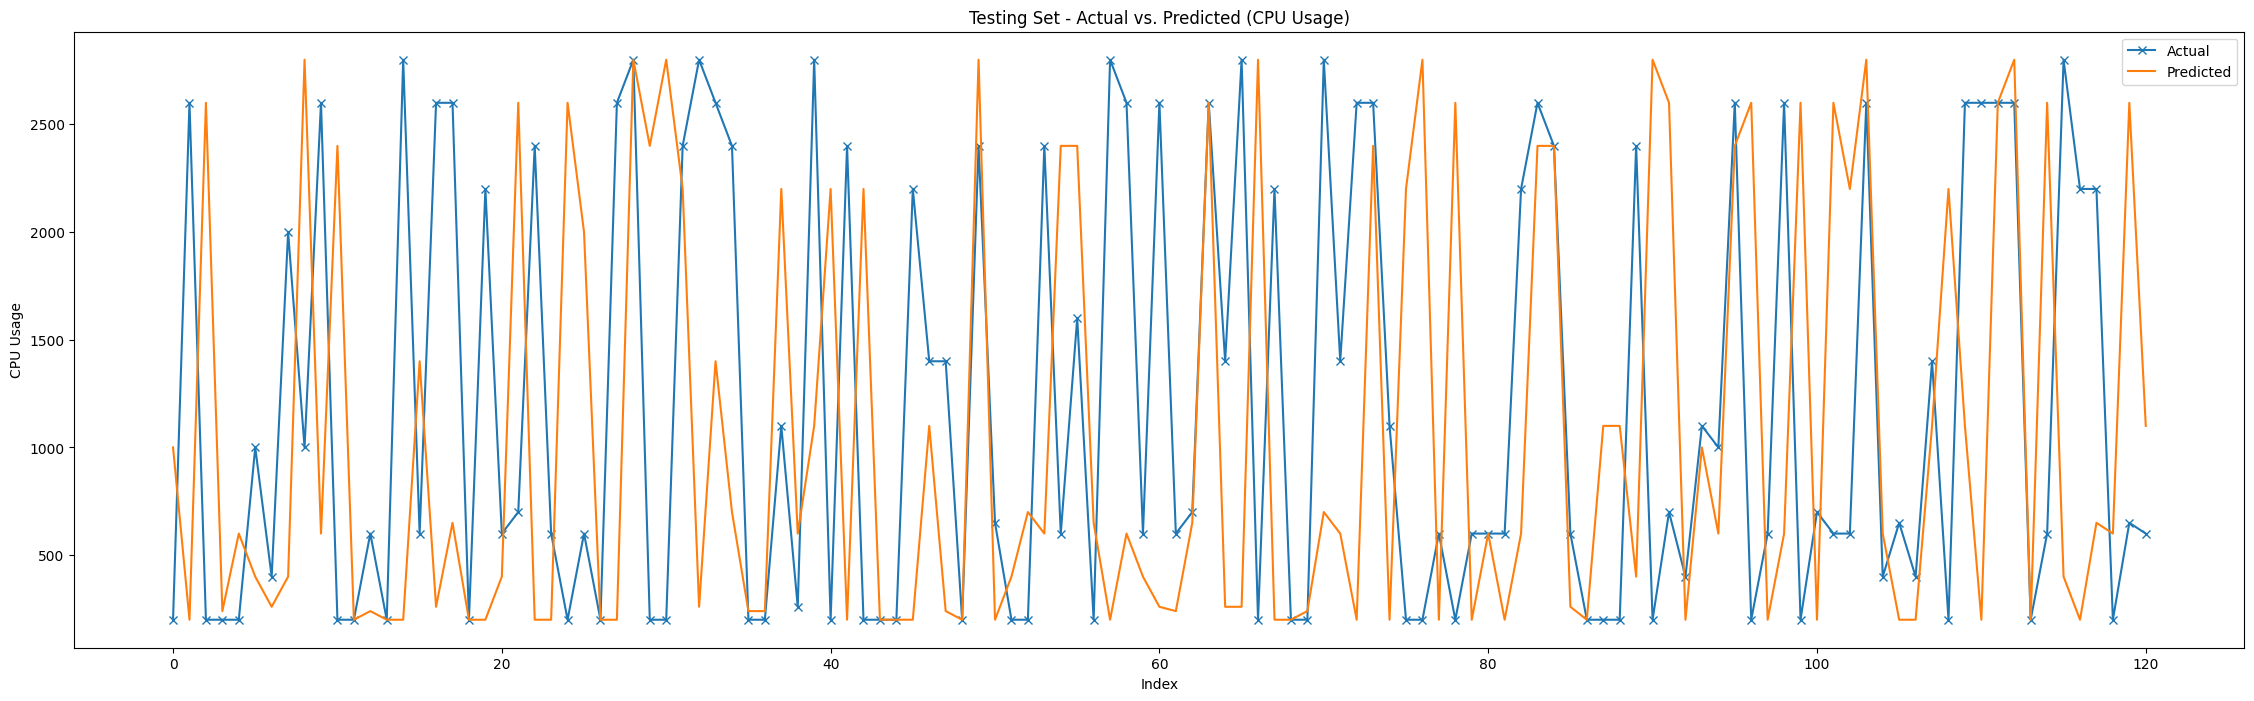

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the data
aggregated_data = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# Separate features and target
features = aggregated_data.drop(['start_time', 'end_time', 'plan_cpu', 'plan_gpu', 'gpu_util'], axis=1)
target_cpu = aggregated_data['cpu_usage']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target_cpu, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define ARIMA order parameter grid for GridSearchCV
param_grid = {
    'order': [(1, 1, 0), (2, 1, 0), (1, 0, 0)],
}

# Define custom scorer for ARIMA model evaluation
def arima_scorer(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)

# Initialize best MAE score with a large value
best_mae_score = float('inf')
best_arima_model = None

# Iterate over parameter grid
for params in ParameterGrid(param_grid):
    # Initialize ARIMA model
    try:
        arima_model = sm.tsa.ARIMA(y_train.values, exog=X_train_scaled, order=params['order'])
        # Fit ARIMA model
        arima_result = arima_model.fit()
        # Make predictions on the test set
        y_test_pred = arima_result.predict(start=0, end=len(X_test_scaled)-1, exog=X_test_scaled)
        # Evaluate the performance
        mae_score = arima_scorer(y_test, y_test_pred)
        # Update best MAE score and best model if current model performs better
        if mae_score < best_mae_score:
            best_mae_score = mae_score
            best_params = params
            best_arima_model = arima_model
    except Exception as e:
        print(f"Error occurred for parameter {params}: {e}")

# Print the best ARIMA order and corresponding MAE score
print("Best ARIMA Order:", best_params)
print("Best MAE Score:", best_mae_score)

# If a best model is found, fit it and make predictions
if best_arima_model is not None:
    best_arima_model_fit = best_arima_model.fit()
    y_test_pred = best_arima_model_fit.predict(start=0, end=len(X_test_scaled)-1, exog=X_test_scaled)

    # Evaluate the performance
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f'Mean Absolute Error (Testing Set - CPU Usage): {mae_test}')
    print(f'Mean Squared Error (Testing Set - CPU Usage): {mse_test}')

    # Plotting the results
    plt.figure(figsize=(28, 8))
    plt.plot(y_test.values, label='Actual', linestyle='-', marker='x')
    plt.plot(y_test_pred, label='Predicted')
    plt.title('Testing Set - Actual vs. Predicted (CPU Usage)')
    plt.xlabel('Index')
    plt.ylabel('CPU Usage')
    plt.legend()
    plt.show()
else:
    print("No suitable model found.")


## MLP


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Hyperparameters (CPU Usage): {'activation': 'relu', 'alpha': 1e-06, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01, 'max_iter': 400}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Absolute Error (Testing Set - CPU Usage): 0.13422819339627307
R-squared (Testing Set - CPU Usage): 1.0000


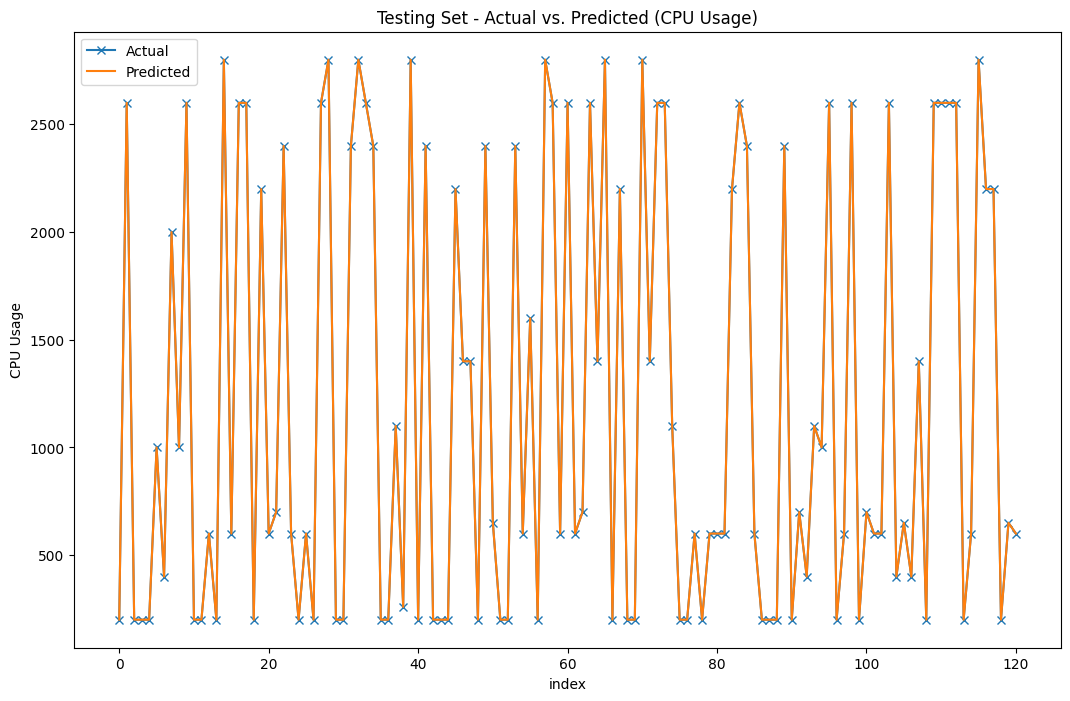

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pywt
import numpy as np

# Load the data
aggregated_data = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# Separate features and target
features = aggregated_data.drop(['start_time', 'end_time', 'plan_cpu', 'plan_gpu', 'gpu_util'], axis=1)
target_cpu = aggregated_data['cpu_usage']

# Function for wavelet transform
def wavelet_transform(data, wavelet='db1', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    flattened_coeffs = np.array([item for sublist in coeffs for item in sublist], dtype=float)
    return flattened_coeffs

# Apply wavelet transform
X_wavelet = features.apply(lambda row: wavelet_transform(row), axis=1)

# Split the dataset into train and test sets
X_train_wavelet, X_test_wavelet, y_train, y_test = train_test_split(X_wavelet, target_cpu, test_size=0.2, random_state=42)

# Scale the wavelet-transformed features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(list(X_train_wavelet)))
X_test_scaled = scaler.transform(np.array(list(X_test_wavelet)))

# Initialize MLP Regressor
mlp = MLPRegressor(random_state=42, solver='adam')

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(100, 100), (200, 100, 50), (50, 50, 150, 150)],
    'alpha': [0.0001, 0.00001, 0.000001],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh'],
    'max_iter': [200, 300, 400],
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best Hyperparameters (CPU Usage):", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Fit the best model on the training data
best_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Evaluate the performance
mae_test = mean_absolute_error(y_test, y_test_pred)
r_squared_test = r2_score(y_test, y_test_pred)
print(f'Mean Absolute Error (Testing Set - CPU Usage): {mae_test}')
print(f'R-squared (Testing Set - CPU Usage): {r_squared_test:.4f}')

# Plotting the results
plt.figure(figsize=(28, 8))
plt.subplot(1, 2, 2)
plt.plot(y_test.values, label='Actual', linestyle='-', marker='x')
plt.plot(y_test_pred, label='Predicted')
plt.title('Testing Set - Actual vs. Predicted (CPU Usage)')
plt.xlabel('index')
plt.ylabel('CPU Usage')
plt.legend()

plt.show()


BI-LSTM

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Hyperparameters (CPU Usage): {'activation': 'relu', 'alpha': 1e-06, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01, 'max_iter': 400}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Absolute Error (Testing Set - CPU Usage): 0.13422819339627307
Mean Squared Error (Testing Set - CPU Usage): 0.02654276092670331
R-squared (Testing Set - CPU Usage): 1.0000


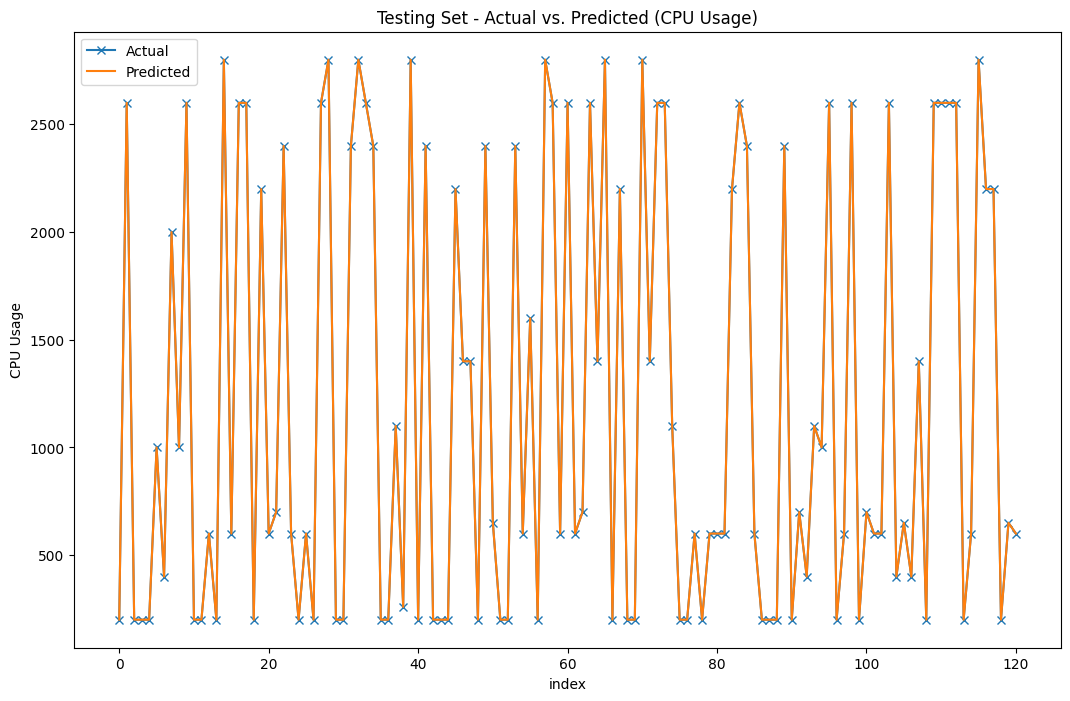

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pywt
import numpy as np

# Load the data
aggregated_data = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# Separate features and target
features = aggregated_data.drop(['start_time', 'end_time', 'plan_cpu', 'plan_gpu', 'gpu_util'], axis=1)
target_cpu = aggregated_data['cpu_usage']

# Function for wavelet transform
def wavelet_transform(data, wavelet='db1', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    flattened_coeffs = np.array([item for sublist in coeffs for item in sublist], dtype=float)
    return flattened_coeffs

# Apply wavelet transform
X_wavelet = features.apply(lambda row: wavelet_transform(row), axis=1)

# Split the dataset into train and test sets
X_train_wavelet, X_test_wavelet, y_train, y_test = train_test_split(X_wavelet, target_cpu, test_size=0.2, random_state=42)

# Scale the wavelet-transformed features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(list(X_train_wavelet)))
X_test_scaled = scaler.transform(np.array(list(X_test_wavelet)))

# Initialize MLP Regressor with regularization
mlp = MLPRegressor(random_state=42, solver='adam')

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(100, 100), (200, 100, 50), (50, 50, 150, 150)],
    'alpha': [0.0001, 0.00001, 0.000001],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh'],
    'max_iter': [200, 300, 400],  # More values for max_iter
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best Hyperparameters (CPU Usage):", grid_search.best_params_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Fit the best model on the training data
best_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Evaluate the performance
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r_squared_test = r2_score(y_test, y_test_pred)
print(f'Mean Absolute Error (Testing Set - CPU Usage): {mae_test}')
print(f'Mean Squared Error (Testing Set - CPU Usage): {mse_test}')
print(f'R-squared (Testing Set - CPU Usage): {r_squared_test:.4f}')

# Plotting the results
plt.figure(figsize=(28, 8))
plt.subplot(1, 2, 2)
plt.plot(y_test.values, label='Actual', linestyle='-', marker='x')
plt.plot(y_test_pred, label='Predicted')
plt.title('Testing Set - Actual vs. Predicted (CPU Usage)')
plt.xlabel('index')
plt.ylabel('CPU Usage')
plt.legend()

plt.show()


GRU


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Epoch 1/1000
13/13 [==============================] - 4s 56ms/step - loss: 1218.3296 - val_loss: 1325.3098
Epoch 2/1000
13/13 [==============================] - 0s 16ms/step - loss: 1217.2369 - val_loss: 1322.8630
Epoch 3/1000
13/13 [==============================] - 0s 21ms/step - loss: 1212.7393 - val_loss: 1313.3958
Epoch 4/1000
13/13 [==============================] - 0s 21ms/step - loss: 1196.6632 - val_loss: 1282.0736
Epoch 5/1000
13/13 [==============================] - 0s 23ms/step - loss: 1147.8425 - val_loss: 1191.9208
Epoch 6/1000
13/13 [==============================] - 0s 19ms/step - loss: 1013.7886 - val_loss: 986.2376
Epoch 7/1000
13/13 [==============================] - 0s 16ms/step - loss: 824.1469 - val_loss: 740.1049
Epoch 8/1000
13/13 [==============================] - 0s 17ms/step - loss: 675.4035 - val_loss: 593.5606
Epoch 9/1000
13/13 [==============================] - 0s 16ms/step - loss: 595.7403 - val_loss: 514.4659
Epoch 10/1000
13/13 [=======================

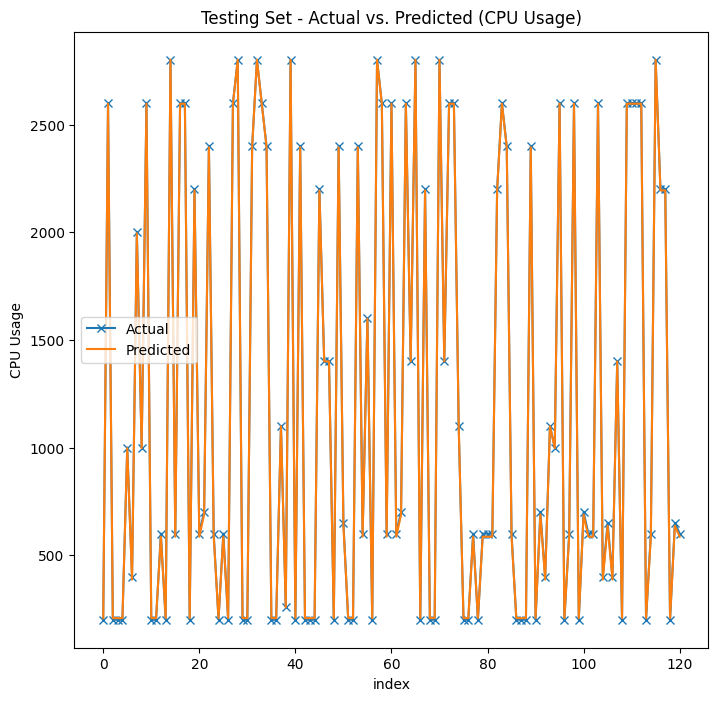

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pywt
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load the data
aggregated_data = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# Separate features and target
features = aggregated_data.drop(['start_time', 'end_time', 'plan_cpu', 'plan_gpu', 'gpu_util'], axis=1)
target_cpu = aggregated_data['cpu_usage']

# Function for wavelet transform
def wavelet_transform(data, wavelet='db1', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    flattened_coeffs = np.array([item for sublist in coeffs for item in sublist], dtype=float)
    return flattened_coeffs

# Apply wavelet transform
X_wavelet = features.apply(lambda row: wavelet_transform(row), axis=1)

# Split the dataset into train and test sets
X_train_wavelet, X_test_wavelet, y_train, y_test = train_test_split(X_wavelet, target_cpu, test_size=0.2, random_state=42)

# Normalize the wavelet-transformed features using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(np.array(list(X_train_wavelet)))
X_test_scaled = scaler.transform(np.array(list(X_test_wavelet)))

# Reshape the input data for GRU
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build a more complex GRU model
model = Sequential()
model.add(GRU(300, input_shape=(1, X_train_scaled.shape[1]), activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(lr=0.0000001), loss='mean_absolute_error')

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model for more epochs with early stopping
history = model.fit(X_train_reshaped, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Make predictions on the test set
y_test_pred = model.predict(X_test_reshaped)

# Evaluate the performance
mae_test = mean_absolute_error(y_test, y_test_pred)
r_squared_test = r2_score(y_test, y_test_pred)
print(f'Mean Absolute Error (Testing Set - CPU Usage): {mae_test}')
print(f'R-squared (Testing Set - CPU Usage): {r_squared_test:.4f}')



# Plotting the results
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 2)
plt.plot(y_test.values, label='Actual', linestyle='-', marker='x')
plt.plot(y_test_pred, label='Predicted')
plt.title('Testing Set - Actual vs. Predicted (CPU Usage)')
plt.xlabel('index')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Epoch 21/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 22/50
13/13 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 23/50
13/13 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 24/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 25/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 26/50
13/13 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 27/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 28/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 29/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 30/50
13/13 [==============================] - 0

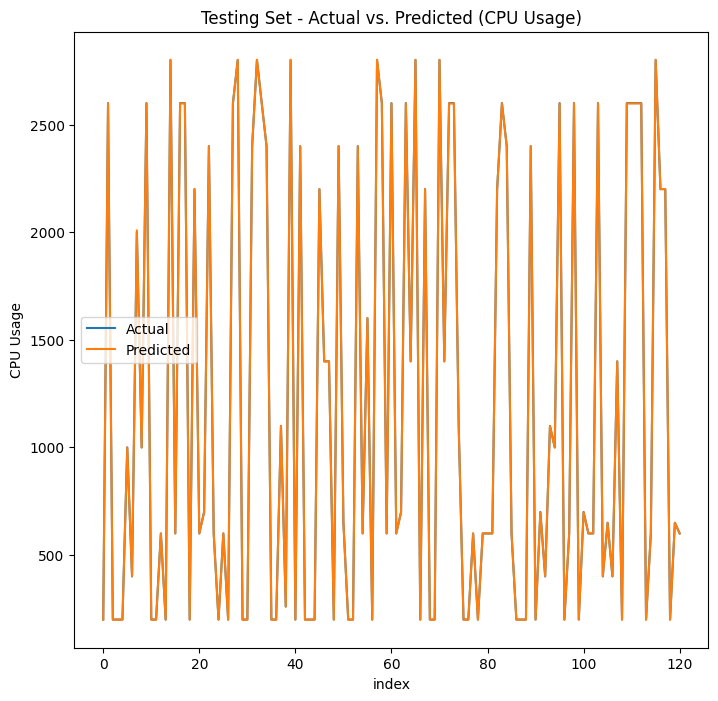

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_squared_log_error
import matplotlib.pyplot as plt
import numpy as np
import pywt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
aggregated_data = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# Separate features and target
features = aggregated_data.drop(['start_time', 'end_time', 'plan_cpu', 'plan_gpu', 'gpu_util'], axis=1)
target_cpu = aggregated_data['cpu_usage']

# Function for wavelet transform
def wavelet_transform(data, wavelet='db1', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    flattened_coeffs = np.array([item for sublist in coeffs for item in sublist], dtype=float)
    return flattened_coeffs

# Apply wavelet transform to each row of features
X_wavelet = features.apply(lambda row: wavelet_transform(row), axis=1)

# Split the dataset into train and test sets
X_train_wavelet, X_test_wavelet, y_train, y_test = train_test_split(X_wavelet, target_cpu, test_size=0.2, random_state=42)

# Scale the wavelet-transformed features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(list(X_train_wavelet)))
X_test_scaled = scaler.transform(np.array(list(X_test_wavelet)))

# Reshape data for Bi-LSTM input
X_train_bi_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_bi_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Normalize the target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = target_scaler.transform(np.array(y_test).reshape(-1, 1))

# Define the Bi-LSTM model using TensorFlow
def create_bi_lstm_model(learning_rate=0.01, units=50):
    model = tf.keras.Sequential()

    # Bidirectional LSTM layer
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units, activation='relu'),
        input_shape=(X_train_bi_lstm.shape[1], X_train_bi_lstm.shape[2])
    ))

    # Dense output layer
    model.add(tf.keras.layers.Dense(1))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Create a custom training loop for hyperparameter tuning
def train_model(model, X_train, y_train, learning_rate, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

    return model

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'units': [50, 100, 150],
    'batch_size': [32, 64, 128],
    'epochs': [50, 100],
}

best_mse = float('inf')
best_hyperparameters = {}

# Grid search for hyperparameter tuning
for lr in param_grid['learning_rate']:
    for units in param_grid['units']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                model = create_bi_lstm_model(learning_rate=lr, units=units)
                trained_model = train_model(model, X_train_bi_lstm, y_train_scaled, learning_rate=lr, epochs=epochs, batch_size=batch_size)

                # Make predictions on the test set
                y_test_pred_scaled = trained_model.predict(X_test_bi_lstm)

                # Inverse transform the predictions
                y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled)

                # Evaluate the performance
                mse_test = mean_squared_error(y_test, y_test_pred)

                # Check if this combination has the lowest MSE
                if mse_test < best_mse:
                    best_mse = mse_test
                    best_hyperparameters = {'learning_rate': lr, 'units': units, 'batch_size': batch_size, 'epochs': epochs}

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

# Create the final model with the best hyperparameters
final_model = create_bi_lstm_model(learning_rate=best_hyperparameters['learning_rate'],
                                   units=best_hyperparameters['units'])
final_model = train_model(final_model, X_train_bi_lstm, y_train_scaled,
                           learning_rate=best_hyperparameters['learning_rate'],
                           epochs=best_hyperparameters['epochs'],
                           batch_size=best_hyperparameters['batch_size'])

# Make predictions on the test set
y_test_pred_scaled = final_model.predict(X_test_bi_lstm)

# Inverse transform the predictions
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled)

# Evaluate the performance
mse_test = mean_squared_error(y_test, y_test_pred)
r_squared_test = r2_score(y_test, y_test_pred)
print(f'Mean Squared Error (Testing Set - CPU Usage): {mse_test}')
print(f'R-squared (Testing Set - CPU Usage): {r_squared_test:.4f}')

# Plotting the results
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 2)
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title('Testing Set - Actual vs. Predicted (CPU Usage)')
plt.xlabel('index')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Hyperparameters (MLP): {'activation': 'relu', 'alpha': 1e-06, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01, 'max_iter': 400}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Mean Absolute Error (Testing Set - CPU Usage): 0.13422819339627307
MLP R-squared (Testing Set - CPU Usage): 1.0000


Streaming output truncated to the last 5000 lines.
13/13 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 36/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 37/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 38/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 39/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 40/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 41/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 42/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 43/100
13/13 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 44/100
13/13 [==============================] -

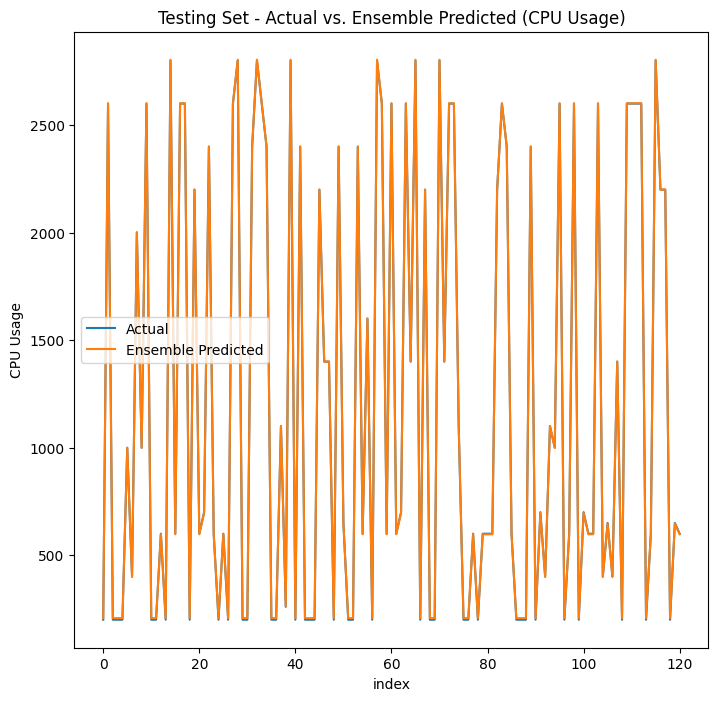

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_squared_log_error
import matplotlib.pyplot as plt
import pywt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
aggregated_data = pd.read_csv('/content/drive/MyDrive/dataset2.csv')

# Separate features and target
features = aggregated_data.drop(['start_time', 'end_time', 'plan_cpu', 'plan_gpu', 'gpu_util'], axis=1)
target_cpu = aggregated_data['cpu_usage']

# Function for wavelet transform
def wavelet_transform(data, wavelet='db1', level=5):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    flattened_coeffs = np.array([item for sublist in coeffs for item in sublist], dtype=float)
    return flattened_coeffs

# Apply wavelet transform to each row of features
X_wavelet = features.apply(lambda row: wavelet_transform(row), axis=1)

# Split the dataset into train and test sets
X_train_wavelet, X_test_wavelet, y_train, y_test = train_test_split(X_wavelet, target_cpu, test_size=0.2, random_state=42)

# Scale the wavelet-transformed features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(list(X_train_wavelet)))
X_test_scaled = scaler.transform(np.array(list(X_test_wavelet)))

# Reshape data for Bi-LSTM input
X_train_bi_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_bi_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Normalize the target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = target_scaler.transform(np.array(y_test).reshape(-1, 1))

# -------------------------- MLP Regressor --------------------------

# Initialize MLP Regressor
mlp = MLPRegressor(random_state=42, solver='adam')

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(100, 100), (200, 100, 50), (50, 50, 150, 150)],
    'alpha': [0.0001, 0.00001, 0.000001],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh'],
    'max_iter': [200, 300, 400],  # More values for max_iter
}

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best Hyperparameters (MLP):", grid_search.best_params_)

# Get the best model from the grid search
mlp_model = grid_search.best_estimator_

# Fit the best MLP model on the training data
mlp_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
mlp_predictions = mlp_model.predict(X_test_scaled)

# Evaluate the performance of MLP model
mlp_mae = mean_absolute_error(y_test, mlp_predictions)
mlp_r_squared = r2_score(y_test, mlp_predictions)
print(f'MLP Mean Absolute Error (Testing Set - CPU Usage): {mlp_mae}')
print(f'MLP R-squared (Testing Set - CPU Usage): {mlp_r_squared:.4f}')

# -------------------------- GRU --------------------------

# Normalize the wavelet-transformed features using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled_gru = scaler.fit_transform(np.array(list(X_train_wavelet)))
X_test_scaled_gru = scaler.transform(np.array(list(X_test_wavelet)))

# Reshape the input data for GRU
X_train_reshaped_gru = X_train_scaled_gru.reshape((X_train_scaled_gru.shape[0], 1, X_train_scaled_gru.shape[1]))
X_test_reshaped_gru = X_test_scaled_gru.reshape((X_test_scaled_gru.shape[0], 1, X_test_scaled_gru.shape[1]))

# Build a more complex GRU model
gru_model = Sequential()
gru_model.add(GRU(300, input_shape=(1, X_train_scaled_gru.shape[1]), activation='relu', return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(200, activation='relu'))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(100, activation='relu'))
gru_model.add(Dense(1))

# Compile the GRU model with a lower learning rate
gru_model.compile(optimizer=Adam(lr=0.0000001), loss='mean_absolute_error')

# Implement early stopping for GRU
early_stopping_gru = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the GRU model for more epochs with early stopping
history_gru = gru_model.fit(X_train_reshaped_gru, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping_gru])

# Make predictions on the test set using GRU model
gru_predictions = gru_model.predict(X_test_reshaped_gru)

# Evaluate the performance of GRU model
gru_mae = mean_absolute_error(y_test, gru_predictions)
gru_r_squared = r2_score(y_test, gru_predictions)
print(f'GRU Mean Absolute Error (Testing Set - CPU Usage): {gru_mae}')
print(f'GRU R-squared (Testing Set - CPU Usage): {gru_r_squared:.4f}')

# -------------------------- Bi-LSTM --------------------------

# Define the Bi-LSTM model using TensorFlow
def create_bi_lstm_model(learning_rate=0.01, units=50):
    model = tf.keras.Sequential()
    model.add(Bidirectional(LSTM(units, activation='relu'), input_shape=(X_train_bi_lstm.shape[1], X_train_bi_lstm.shape[2])))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create a custom training loop for hyperparameter tuning
def train_model(model, X_train, y_train, learning_rate, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])
    return model

# Define hyperparameter grid for GridSearchCV
param_grid_bi_lstm = {
    'learning_rate': [0.001, 0.01, 0.1],
    'units': [50, 100, 150],
    'batch_size': [32, 64, 128],
    'epochs': [50, 100],
}

best_mse = float('inf')
best_hyperparameters = {}

# Grid search for hyperparameter tuning for Bi-LSTM
for lr in param_grid_bi_lstm['learning_rate']:
    for units in param_grid_bi_lstm['units']:
        for batch_size in param_grid_bi_lstm['batch_size']:
            for epochs in param_grid_bi_lstm['epochs']:
                model = create_bi_lstm_model(learning_rate=lr, units=units)
                trained_model = train_model(model, X_train_bi_lstm, y_train_scaled, learning_rate=lr, epochs=epochs, batch_size=batch_size)
                # Make predictions on the test set
                y_test_pred_scaled = trained_model.predict(X_test_bi_lstm)
                # Inverse transform the predictions
                y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled)
                # Evaluate the performance
                mse_test = mean_squared_error(y_test, y_test_pred)
                # Check if this combination has the lowest MSE
                if mse_test < best_mse:
                    best_mse = mse_test
                    best_hyperparameters = {'learning_rate': lr, 'units': units, 'batch_size': batch_size, 'epochs': epochs}

# Print the best hyperparameters for Bi-LSTM
print("Best Hyperparameters (Bi-LSTM):", best_hyperparameters)

# Create the final Bi-LSTM model with the best hyperparameters
final_bi_lstm_model = create_bi_lstm_model(learning_rate=best_hyperparameters['learning_rate'], units=best_hyperparameters['units'])
final_bi_lstm_model = train_model(final_bi_lstm_model, X_train_bi_lstm, y_train_scaled,
                                   learning_rate=best_hyperparameters['learning_rate'],
                                   epochs=best_hyperparameters['epochs'],
                                   batch_size=best_hyperparameters['batch_size'])

# Make predictions on the test set using the final Bi-LSTM model
y_test_pred_scaled_bi_lstm = final_bi_lstm_model.predict(X_test_bi_lstm)

# Inverse transform the predictions
y_test_pred_bi_lstm = target_scaler.inverse_transform(y_test_pred_scaled_bi_lstm)

# Evaluate the performance of the final Bi-LSTM model
bi_lstm_mse = mean_squared_error(y_test, y_test_pred_bi_lstm)
bi_lstm_r_squared = r2_score(y_test, y_test_pred_bi_lstm)
print(f'Bi-LSTM Mean Squared Error (Testing Set - CPU Usage): {bi_lstm_mse}')
print(f'Bi-LSTM R-squared (Testing Set - CPU Usage): {bi_lstm_r_squared:.4f}')

# -------------------------- Ensemble --------------------------

# Ensemble the predictions
ensemble_predictions = (mlp_predictions + gru_predictions.flatten() + y_test_pred_bi_lstm.flatten()) / 3

# Evaluate the performance of the ensemble
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)
ensemble_r_squared = r2_score(y_test, ensemble_predictions)

print(f'Ensemble Mean Absolute Error (Testing Set - CPU Usage): {ensemble_mae}')
print(f'Ensemble R-squared (Testing Set - CPU Usage): {ensemble_r_squared:.4f}')

# Plotting the results
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 2)
plt.plot(y_test.values, label='Actual')
plt.plot(ensemble_predictions, label='Ensemble Predicted')
plt.title('Testing Set - Actual vs. Ensemble Predicted (CPU Usage)')
plt.xlabel('index')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()


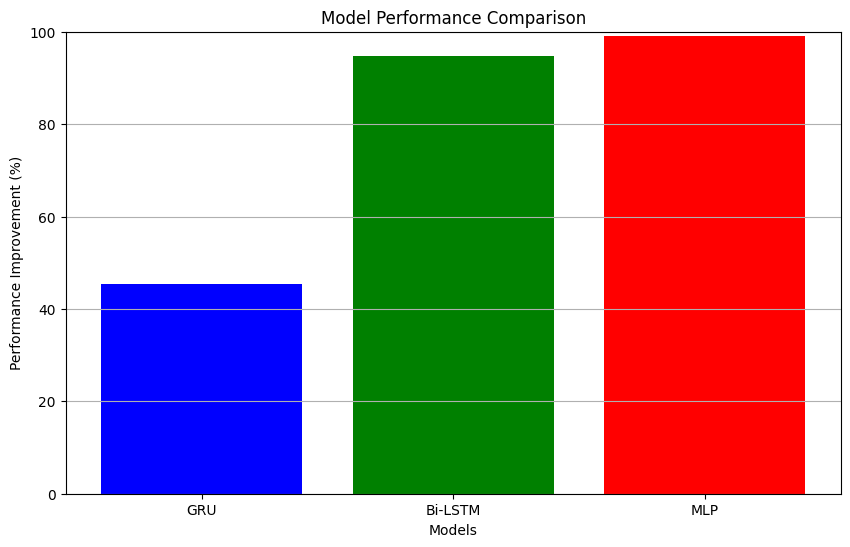

In [ ]:
import math
import matplotlib.pyplot as plt

arima_mse = 1127.36

arima_mae = math.sqrt(arima_mse)

maes = {
    "GRU": 18.35,
    "Bi-LSTM": 1.80,
    "MLP": 0.31
}
performance_percentages = {}
for model, mae in maes.items():
    performance_percentage = (1 - (mae / arima_mae)) * 100
    performance_percentages[model] = performance_percentage


models = list(performance_percentages.keys())
percentages = list(performance_percentages.values())

plt.figure(figsize=(10, 6))
plt.bar(models, percentages, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Performance Improvement (%)')
plt.title('Model Performance Comparison')
plt.ylim(0, 100)
plt.grid(axis='y')

plt.show()
